Traffic Sign Classification

We begin by importing all the necessary libraries that will be used

In [1]:
#importing Libraries for data analysis
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
import ipywidgets as widgets
import pickle
import seaborn as sns
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import random
import csv
import cv2
import skimage.morphology as morp
from skimage.filters import rank

We will use Python pickle to load the data.

In [2]:
with open("./dataset/train.p", mode='rb') as d:
    train = pickle.load(d)
with open("./dataset/valid.p", mode='rb') as d:
    valid = pickle.load(d)
with open("./dataset/test.p", mode='rb') as d:
    test = pickle.load(d)

    
x_train, y_train = train['features'], train['labels']
x_valid, y_valid = valid['features'], valid['labels']
x_testr, y_test = test['features'], test['labels']

n_train = x_train.shape[0]
n_validation = x_valid.shape[0]
n_test = x_testr.shape[0]
image_shape = x_train.shape[1:]
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [3]:
signdata = []
with open('signid.csv', 'r') as d:
    signid = csv.reader(d, delimiter=',')
    next(signid,None)
    for row in signid:
        signdata.append(row[1])
    


In [4]:
# Shuffle the dataset 
from sklearn.utils import shuffle
x_train, y_train = shuffle(x_train, y_train)


Here is a simple histogram of our classes distribution

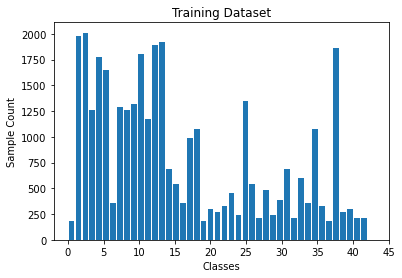

In [5]:
hist, bins = np.histogram(y_train, 43)
height = (bins[:-1] + bins[1:]) / 2
plt.bar(height, hist)
plt.title("Training Dataset")
plt.xticks([0,5,10,15,20,25,30,35,40,45])
plt.xlabel("Classes")
plt.ylabel("Sample Count")
plt.show()

In [6]:
def list_images(dataset, dataset_y, ylabel="", cmap=None):
    plt.figure(figsize=(15, 16))
    for i in range(6):
        plt.subplot(1, 6, i+1)
        indx = random.randint(0, len(dataset))
        #Use gray scale color map if there is only one channel
        cmap = 'gray' if len(dataset[indx].shape) == 2 else cmap
        plt.imshow(dataset[indx], cmap = cmap)
        plt.xlabel(signdata[dataset_y[indx]])
        plt.ylabel(ylabel)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

Once data exploration is done, we proceed to clean our datasets


In [7]:
import cv2
import skimage.morphology as morp

In [8]:
import cv2
def gray(img):
    return cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)


def equalize(img):
    return cv2.equalizeHist(img)


def local_histo_equalize(img):
    kernel = morp.disk(30)
    return rank.equalize(img, selem=kernel)

def preprocess(img):
    img = gray(img)
    img =local_histo_equalize(img)
    img = equalize(img)
    #now normalizing the images
    img = img/255
    return img
  

In [9]:
x_train= np.array(list(map(preprocess,x_train)))
x_test = np.array(list(map(preprocess,x_testr)))
x_val = np.array(list(map(preprocess,x_valid)))

In [10]:
#reshaping the images

x_train = x_train.reshape(34799, 32, 32, 1)
x_test = x_test.reshape(12630, 32, 32, 1)
x_val = x_val.reshape(4410, 32, 32, 1)

print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

(34799, 32, 32, 1)
(12630, 32, 32, 1)
(4410, 32, 32, 1)


Model Training

In [11]:
cnn_model = Sequential()

cnn_model.add(Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(32,32,1)))
cnn_model.add(AveragePooling2D())
cnn_model.add(Conv2D(filters=16, kernel_size=(5, 5), activation='relu'))
cnn_model.add(AveragePooling2D())
cnn_model.add(Flatten())
cnn_model.add(Dense(units=400, activation='relu'))
cnn_model.add(Dense(units=84, activation='relu'))
cnn_model.add(Dense(units=43, activation = 'softmax'))
cnn_model.compile(loss ='sparse_categorical_crossentropy', optimizer='adam',metrics =['accuracy'])

In [12]:
history = cnn_model.fit(x_train,y_train,batch_size=400,epochs=15,verbose=1,validation_data = (x_val,y_valid))

Epoch 1/15
87/87 [==============================] - 16s 61ms/step - loss: 3.2655 - accuracy: 0.1565 - val_loss: 1.8516 - val_accuracy: 0.4680
Epoch 2/15
87/87 [==============================] - 5s 53ms/step - loss: 1.3827 - accuracy: 0.5871 - val_loss: 0.9820 - val_accuracy: 0.7034
Epoch 3/15
87/87 [==============================] - 5s 56ms/step - loss: 0.8346 - accuracy: 0.7485 - val_loss: 0.7912 - val_accuracy: 0.7567
Epoch 4/15
87/87 [==============================] - 5s 56ms/step - loss: 0.6111 - accuracy: 0.8223 - val_loss: 0.6596 - val_accuracy: 0.7966
Epoch 5/15
87/87 [==============================] - 4s 51ms/step - loss: 0.4919 - accuracy: 0.8594 - val_loss: 0.6102 - val_accuracy: 0.8175
Epoch 6/15
87/87 [==============================] - 4s 51ms/step - loss: 0.4081 - accuracy: 0.8846 - val_loss: 0.6178 - val_accuracy: 0.8202
Epoch 7/15
87/87 [==============================] - 5s 53ms/step - loss: 0.3394 - accuracy: 0.9015 - val_loss: 0.5702 - val_accuracy: 0.8324
Epoch 8/15
8

In [13]:
score = cnn_model.evaluate(x_test, y_test,verbose=0)
print('Test Accuracy : {:.4f}'.format(score[1]))


Test Accuracy : 0.8441


In [14]:
history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

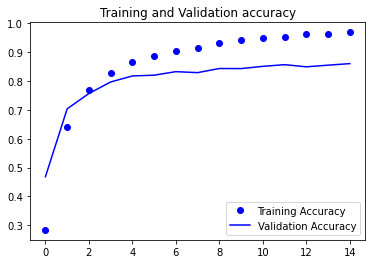

In [15]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

<AxesSubplot:>

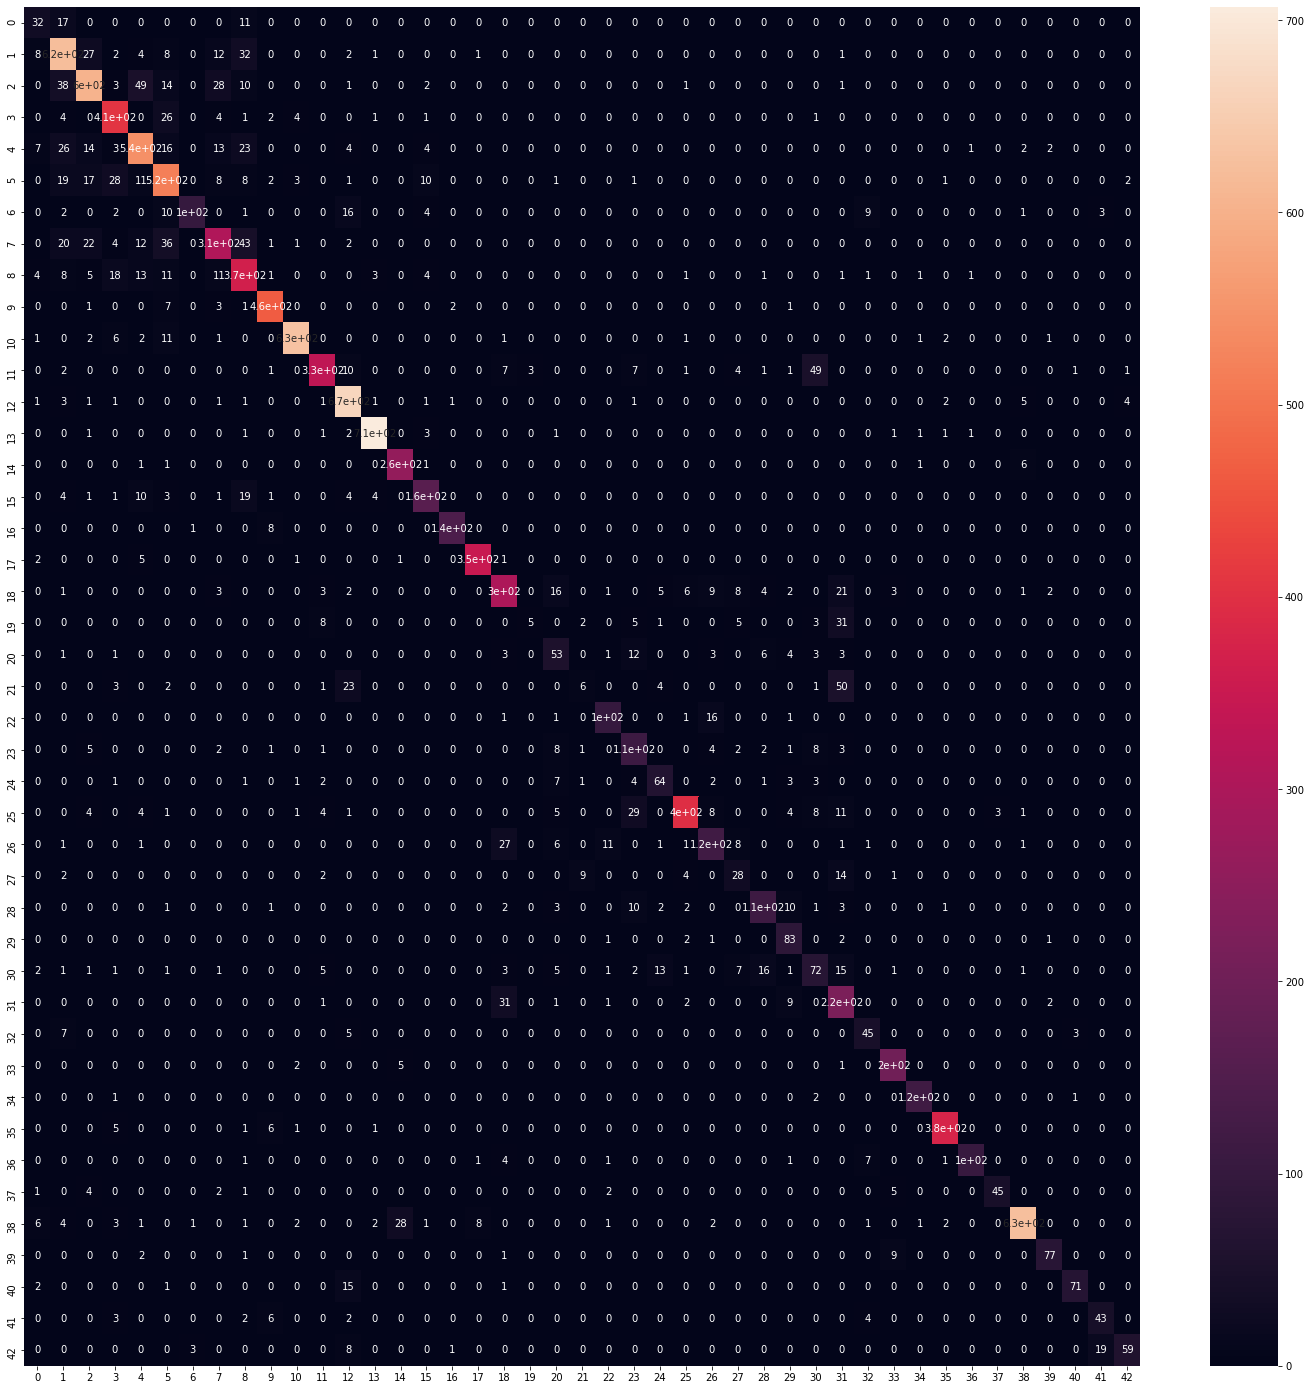

In [16]:
#get the predictions for the test data
predicted_classes = np.argmax(cnn_model.predict(x_test), axis=-1)
#get the indices to be plotted
y_true = y_test

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, predicted_classes)
plt.figure(figsize = (25,25))
sns.heatmap(cm, annot=True)


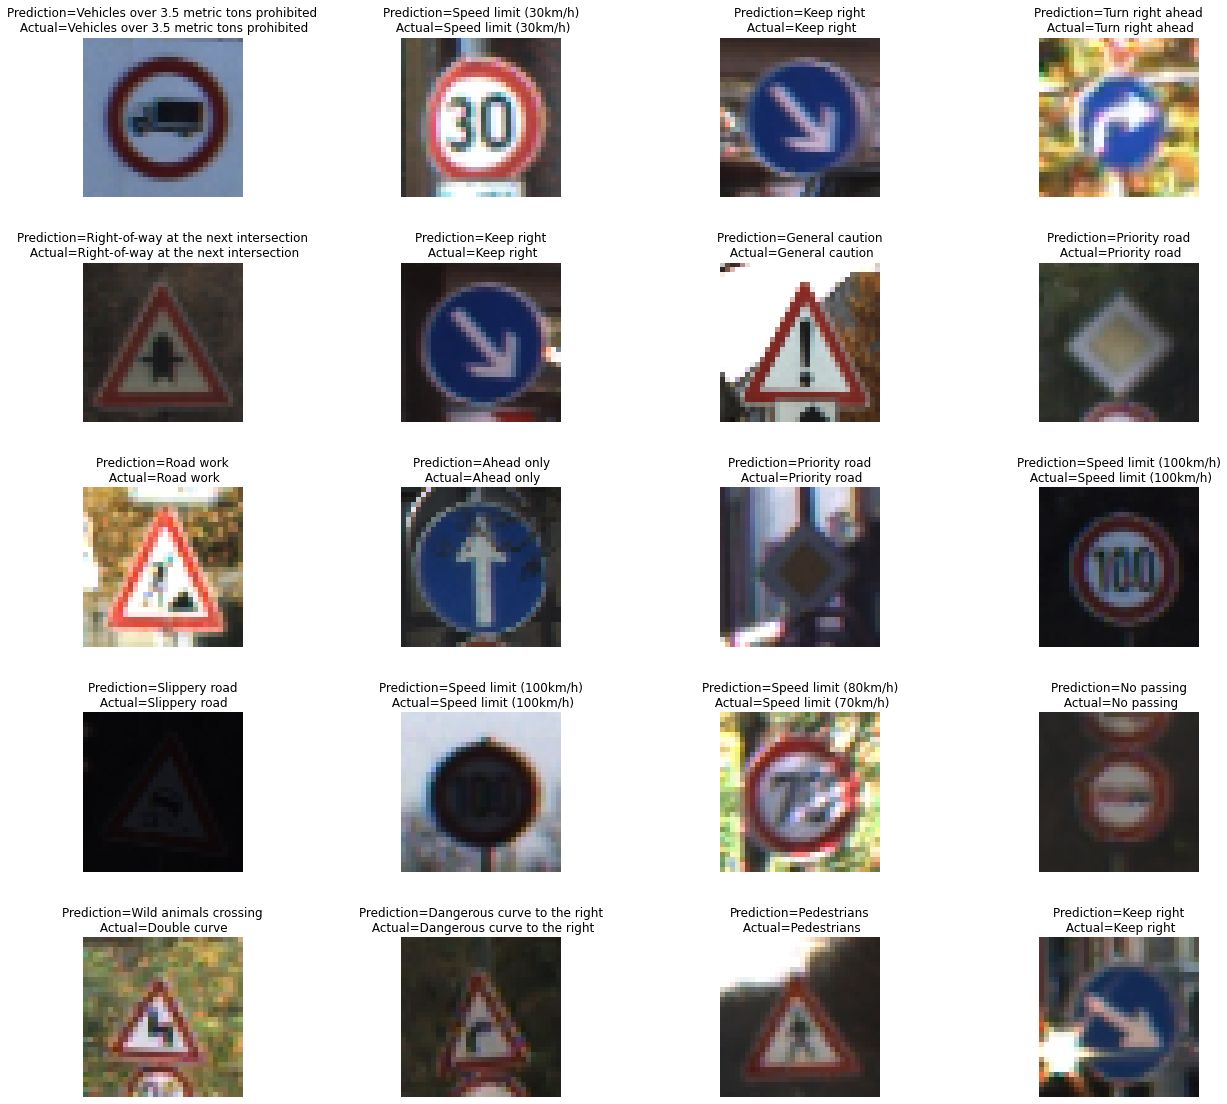

In [17]:
L = 5
W = 4
fig, axes = plt.subplots(L, W, figsize = (20,20))
axes = axes.ravel() # 

for i in np.arange(0, L * W):  
    axes[i].imshow(x_testr[i])
    axes[i].set_title("Prediction={}\n Actual={}".format(signdata[predicted_classes[i]], signdata[y_true[i]]))
    axes[i].axis('off')

plt.subplots_adjust(wspace=1)